In [16]:
import torch
import json
import os
with open("./models_places365/categories_places365.txt") as f:
    categories = [line.strip().split()[0].split('/')[-1] for line in f]
cat_2_idx = {cat : i for i, cat in enumerate(categories)}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

with open('./finetuned_models/resnet50_20251209_111405/config.json') as f:
    config = json.load(f)

print(config)

{'model_name': 'resnet50', 'batch_size': 32, 'num_epochs': 30, 'learning_rate': 0.001, 'weight_decay': 0.0005, 'dropout_rate': 0.5, 'save_dir': './finetuned_models', 'data_dir': './train', 'device': 'cuda', 'gradual_unfreeze': True, 'unfreeze_schedule': [[1, 'classifier', 1.0], [4, 'layer4', 0.1], [7, 'layer3', 0.05], [10, 'layer2', 0.01], [13, 'all', 0.005]], 'overfit_early_stop': True, 'overfit_threshold': 10.0, 'overfit_val_acc_threshold': 80.0, 'overfit_patience': 3, 'early_stopping': True, 'early_stopping_patience': 7, 'early_stopping_min_delta': 0.001}


In [17]:
import torch
import torch.nn as nn
import torchvision.models as models
import re
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image

import os



# ============================================================================
# Model Loading Functions
# ============================================================================

def load_finetuned_model(checkpoint_path, device='cuda'):
    """
    Load a fine-tuned model from checkpoint
    
    Args:
        checkpoint_path: Path to the .pth checkpoint file
        device: 'cuda' or 'cpu'
    
    Returns:
        model: Loaded model in eval mode
        checkpoint: Full checkpoint dict (contains config, class mappings, etc.)

    """
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    
    # Get config
    config = checkpoint['config']
    model_name = config['model_name']
    dropout_rate = config.get('dropout_rate', 0.5)
    
    # Create model architecture
    if model_name == 'resnet18':
        model = models.resnet18(weights=None)
        model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(512, 365)  # 365 Places365 classes
        )
    elif model_name == 'resnet50':
        model = models.resnet50(weights=None)
        model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(2048, 365)
        )
    elif model_name == 'densenet':
        model = models.densenet161(weights=None)
        model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(2208, 365)
        )
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    model.to(device)
    
    print(f"✓ Loaded {model_name} from epoch {checkpoint['epoch']}")
    print(f"  Val Accuracy: {checkpoint['val_acc']:.2f}%")
    print(f"  Val Loss: {checkpoint['val_loss']:.4f}")
    
    return model, checkpoint





# ============================================================================
# Image Preprocessing
# ============================================================================



# ============================================================================
# Inference Functions
# ============================================================================




# ============================================================================
# Example Usage
# ============================================================================


def loadModel(model_name, num_classes=365):
    if model_name == 'resnet18':
        model = models.resnet18(weights=None)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        model_path = "./models_places365/resnet18_places365.pth.tar"
    elif model_name == 'resnet50':
        model = models.resnet50(weights=None)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        model_path = "./models_places365/resnet50_places365.pth.tar"
    elif model_name == 'densenet':
        model = models.densenet161(weights=None)
        num_features = model.classifier.in_features
        model.classifier = nn.Linear(num_features, num_classes)
        model_path = "./models_places365/densenet161_places365.pth.tar"
    else:
        raise ValueError(f"Unknown model name: {model_name}")

    checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
    # Possible keys for different training formats
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    elif 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint  # raw state_dict


    # Remove 'module.' prefix if present (from DataParallel)
    new_state_dict = {}
    for k, v in state_dict.items():
        name = k.replace('module.', '')
        
        # Fix DenseNet naming: convert 'norm.1' -> 'norm1', 'conv.2' -> 'conv2', etc.
        # This handles the old checkpoint format vs new torchvision format
        if model_name == 'densenet':
            name = re.sub(r'\.(\d+)\.', lambda m: m.group(1) + '.', name)
        
        new_state_dict[name] = v

    # Load weights
    try:
        model.load_state_dict(new_state_dict, strict=True)
        print(f"Successfully loaded {model_name} weights")
    except RuntimeError as e:
        print(f"Warning: Could not load with strict=True, trying strict=False")
        print(f"Error: {e}")
        model.load_state_dict(new_state_dict, strict=False)
    
    model.eval()
    return model



In [18]:
from torchvision import transforms
from PIL import Image

img_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [19]:
from torch.utils.data import Dataset
from torchvision import datasets
from PIL import Image
import numpy as np


class Places(Dataset):
    def __init__(self, img_transform):
        self.labels = []
        self.img_transform = img_transform
        with open('./val_256/places365_val.txt', 'r') as f:
            self.labels = [int(line.strip().split()[-1]) for line in f]
        with open('./val_256/places365_val.txt', 'r') as f:
            self.img_paths = [('./val_256/' + str(line.strip().split()[0])) for line in f]
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):
        image = Image.open(self.img_paths[index]).convert('RGB')
        img_tensor = self.img_transform(image)
        return img_tensor, torch.tensor(self.labels[index], dtype=torch.long)
    



In [20]:
places365_val_dataset = Places(img_transform)





In [21]:
x =  torch.randn([4, 4])
i, p = torch.topk(x, k=2)
p[0][0].item()

0

In [22]:
custom_dataset = datasets.ImageFolder(
    root='./train',
    transform=img_transform
)
new_map = {cls_name: cat_2_idx[cls_name] for cls_name in custom_dataset.classes}

custom_dataset.class_to_idx = new_map
custom_dataset.samples = [
    (path, new_map[class_name])
    for (path, _old_idx) in custom_dataset.samples
    for class_name in [path.split(os.sep)[-2]]
]

custom_dataset.targets = [label for _, label in custom_dataset.samples]
import matplotlib.pyplot as plt
from collections import Counter

In [23]:
from torch.utils.data import DataLoader

places_loader = DataLoader(places365_val_dataset, batch_size=32, shuffle=True)
custom_loader = DataLoader(custom_dataset, batch_size=32, shuffle=True)

In [24]:
import torch
from torchmetrics import Accuracy, Precision, Recall, F1Score
import pandas as pd
from tqdm import tqdm


def evaluate_with_thresholds(model, dataloader, num_classes, thresholds=[i/10 for i in range(10)], device='cuda', custome_targets=None):
    """
    Evaluate precision/recall/f1 at different confidence thresholds
    """
    if custome_targets is None:
        custome_targets = [i for i in range(num_classes)]

    model.eval()
    
    # Collect all predictions first
    all_probs = []
    all_labels = []
    
    print("Collecting predictions...")
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            images = images.to(device)
            logits = model(images)
            probs = torch.softmax(logits, dim=1)
            
            all_probs.append(probs[:, custome_targets].cpu())
            all_labels.append(labels)
    
    all_probs = torch.cat(all_probs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)


    
    # Get top-1 predictions and confidences
    confidences, predictions = torch.max(all_probs, dim=1)
    
    results = []
    print("\nComputing metrics for each threshold...")
    for threshold in tqdm(thresholds, desc="Thresholds"):
        # Filter by threshold
        mask = confidences >= threshold
        
        if mask.sum() == 0:
            print(f"Warning: No predictions above threshold {threshold}")
            continue
        
        filtered_preds = predictions[mask]
        filtered_labels = all_labels[mask]
        
        # Compute metrics on filtered predictions
        acc_metric = Accuracy(task="multiclass", num_classes=num_classes)
        
        prec_macro = Precision(task="multiclass", num_classes=num_classes, average="macro")
        prec_micro = Precision(task="multiclass", num_classes=num_classes, average="micro")
        
        recall_macro = Recall(task="multiclass", num_classes=num_classes, average="macro")
        recall_micro = Recall(task="multiclass", num_classes=num_classes, average="micro")
        
        f1_macro = F1Score(task="multiclass", num_classes=num_classes, average="macro")
        f1_micro = F1Score(task="multiclass", num_classes=num_classes, average="micro")
        
        accuracy = acc_metric(filtered_preds, filtered_labels).item()
        precision_macro = prec_macro(filtered_preds, filtered_labels).item()
        precision_micro = prec_micro(filtered_preds, filtered_labels).item()
        recall_macro = recall_macro(filtered_preds, filtered_labels).item()
        recall_micro = recall_micro(filtered_preds, filtered_labels).item()
        f1_macro = f1_macro(filtered_preds, filtered_labels).item()
        f1_micro = f1_micro(filtered_preds, filtered_labels).item()
        
        coverage = mask.sum().item() / len(all_labels)
        
        results.append({
            'threshold': threshold,
            'accuracy': accuracy,
            'precision_macro': precision_macro,
            'precision_micro': precision_micro,
            'recall_macro': recall_macro,
            'recall_micro': recall_micro,
            'f1_macro': f1_macro,
            'f1_micro': f1_micro,
            'coverage': coverage,
            'num_predictions': mask.sum().item()
        })
    
    return pd.DataFrame(results)


def evaluate_topk_accuracy(model, dataloader, num_classes, k_values=[1, 3, 5], custom_classes = None, device='cuda'):
    """
    Evaluate top-k accuracy for different k values
    
    Args:
        model: PyTorch model
        dataloader: DataLoader for evaluation
        num_classes: Number of classes
        k_values: List of k values for top-k accuracy (e.g., [1, 3, 5])
        device: Device to run evaluation on
    
    Returns:
        DataFrame with top-k accuracy results
    """

    if custom_classes is None:
        custom_classes = [i for i in range(num_classes)]
    model.eval()
    
    # Collect all predictions first
    all_probs = []
    all_labels = []
    
    print("Collecting predictions for top-k evaluation...")
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            images = images.to(device)
            logits = model(images)[:, custom_classes]
            probs = torch.softmax(logits, dim=1)
            
            all_probs.append(probs.cpu())
            all_labels.append(labels)
    
    all_probs = torch.cat(all_probs, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    results = []
    max_k = max(k_values)
    
    # Get top-k predictions (indices)
    _, top_k_indices = torch.topk(all_probs, k=min(max_k, num_classes), dim=1)
    
    print("\nComputing top-k accuracy...")
    for k in tqdm(k_values, desc="Top-K values"):
        if k > num_classes:
            print(f"Warning: k={k} is larger than num_classes={num_classes}, skipping")
            continue
        
        # Check if true label is in top-k predictions
        top_k_preds = top_k_indices[:, :k]
        correct = torch.any(top_k_preds == all_labels.unsqueeze(1), dim=1)
        
        accuracy = correct.float().mean().item()
        num_correct = correct.sum().item()
        total = len(all_labels)
        
        # Also compute average confidence for top-k predictions
        top_k_probs = torch.gather(all_probs, 1, top_k_preds)
        avg_confidence = top_k_probs.mean().item()
        
        results.append({
            'k': k,
            'top_k_accuracy': accuracy,
            'num_correct': num_correct,
            'total_samples': total,
            'avg_top_k_confidence': avg_confidence
        })
    
    return pd.DataFrame(results)




In [34]:
for model in ['resnet18', 'resnet50', 'densenet']:
    result_df = evaluate_topk_accuracy(loadModel(model).to(device), custom_loader, 365, k_values=[1, 3, 5], custom_classes = None, device='cuda')
    result_df.to_csv(f'custom_{model}.csv')

Successfully loaded resnet18 weights


Evaluating:  39%|███▉      | 18/46 [02:10<03:50,  8.23s/it]c:\Users\rohan\anaconda3\envs\pytorch_env\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



Computing top-k accuracy...


Top-K values: 100%|██████████| 3/3 [00:00<00:00, 373.42it/s]


Successfully loaded resnet50 weights



Computing top-k accuracy...


Top-K values: 100%|██████████| 3/3 [00:00<?, ?it/s]


Successfully loaded densenet weights



Computing top-k accuracy...


Top-K values: 100%|██████████| 3/3 [00:00<00:00, 2829.53it/s]


In [33]:
import torch
import time
import psutil
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import gc


def benchmark_batch_sizes(models_dict, dataset, batch_sizes=None, device='cpu', 
                          num_iterations=30, warmup=3, save_dir='./benchmark_results',
                          sample_subset=None):
    """
    Optimized benchmark for multiple models across different batch sizes
    
    Args:
        models_dict: Dictionary of {model_name: model}
        dataset: PyTorch Dataset to use for benchmarking
        batch_sizes: List of batch sizes to test (default: [1, 4, 8, 16, 32])
        device: 'cpu' or 'cuda'
        num_iterations: Number of batches to process (default: 30)
        warmup: Number of warmup iterations (default: 3)
        save_dir: Directory to save results
        sample_subset: If set, use only this many samples from dataset (speeds up testing)
        
    Returns:
        DataFrame with all benchmark results
    """
    if batch_sizes is None:
        batch_sizes = [1, 4, 8, 16, 32]  # Reduced default batch sizes
    
    os.makedirs(save_dir, exist_ok=True)
    
    # Use subset of dataset if specified
    if sample_subset and len(dataset) > sample_subset:
        dataset = torch.utils.data.Subset(dataset, range(sample_subset))
        print(f"Using {sample_subset} samples from dataset for faster benchmarking")
    
    process = psutil.Process(os.getpid())
    all_results = []
    
    for model_name, model in models_dict.items():
        print(f"\n{'='*80}")
        print(f"Benchmarking: {model_name}")
        print(f"{'='*80}")
        
        model = model.to(device)
        model.eval()
        
        # Get model size info (computed once per model)
        param_size = sum(p.numel() * p.element_size() for p in model.parameters())
        buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
        model_size_mb = (param_size + buffer_size) / 1024 / 1024
        num_params = sum(p.numel() for p in model.parameters())
        
        for batch_size in tqdm(batch_sizes, desc=f"{model_name} batch sizes"):
            # Create dataloader for this batch size
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False,  # shuffle=False for consistency
                                   num_workers=0, pin_memory=(device=='cuda'), 
                                   drop_last=True)  # drop_last ensures consistent batch sizes
            
            # Get baseline memory
            if device == 'cpu':
                gc.collect()  # Clean memory before measuring
                baseline_memory = process.memory_info().rss / 1024 / 1024  # MB
            
            # Warmup phase (reduced iterations)
            dataloader_iter = iter(dataloader)
            with torch.no_grad():
                for _ in range(min(warmup, len(dataloader))):
                    try:
                        images, _ = next(dataloader_iter)
                        images = images.to(device, non_blocking=True)
                        _ = model(images)
                        if device == 'cuda':
                            torch.cuda.synchronize()
                    except StopIteration:
                        break
            
            # Clear cache after warmup
            if device == 'cuda':
                torch.cuda.empty_cache()
            
            # Benchmark phase
            times = []
            cpu_usages = []
            memory_usages = []
            
            dataloader_iter = iter(dataloader)
            actual_iterations = min(num_iterations, len(dataloader))
            
            with torch.no_grad():
                for i in range(actual_iterations):
                    try:
                        images, _ = next(dataloader_iter)
                    except StopIteration:
                        break
                    
                    actual_batch_size = images.size(0)
                    images = images.to(device, non_blocking=True)
                    
                    # Measure inference time
                    if device == 'cuda':
                        torch.cuda.synchronize()
                        start = torch.cuda.Event(enable_timing=True)
                        end = torch.cuda.Event(enable_timing=True)
                        start.record()
                        _ = model(images)
                        end.record()
                        torch.cuda.synchronize()
                        batch_time_ms = start.elapsed_time(end)
                    else:
                        start = time.perf_counter()
                        _ = model(images)
                        end = time.perf_counter()
                        batch_time_ms = (end - start) * 1000
                    
                    per_image_time_ms = batch_time_ms / actual_batch_size
                    times.append(per_image_time_ms)
                    
                    # Measure CPU and memory (only on CPU, and sample every 5th iteration)
                    if device == 'cpu' and i % 5 == 0:
                        cpu_usages.append(process.cpu_percent(interval=None))
                        memory_usages.append(process.memory_info().rss / 1024 / 1024)
            
            # Clear cache after benchmark
            if device == 'cuda':
                torch.cuda.empty_cache()
            
            # Compute statistics using percentiles for robustness
            times_array = np.array(times)
            result = {
                'model': model_name,
                'batch_size': batch_size,
                'device': device,
                'model_size_mb': model_size_mb,
                'num_parameters_millions': num_params / 1e6,
                'iterations_completed': len(times),
                
                # Time metrics (using percentiles to filter outliers)
                'mean_time_per_image_ms': np.mean(times_array),
                'std_time_per_image_ms': np.std(times_array),
                'min_time_per_image_ms': np.percentile(times_array, 5),  # 5th percentile
                'max_time_per_image_ms': np.percentile(times_array, 95),  # 95th percentile
                'median_time_per_image_ms': np.median(times_array),
                
                # Throughput
                'throughput_images_per_sec': 1000.0 / np.mean(times_array),
                'batch_throughput_batches_per_sec': 1000.0 / (np.mean(times_array) * batch_size),
            }
            
            # Add CPU/memory metrics for CPU device
            if device == 'cpu' and cpu_usages:
                result.update({
                    'mean_cpu_percent': np.mean(cpu_usages),
                    'max_cpu_percent': np.max(cpu_usages),
                    'mean_memory_mb': np.mean(memory_usages) if memory_usages else 0,
                    'max_memory_mb': np.max(memory_usages) if memory_usages else 0,
                    'memory_increase_mb': (np.mean(memory_usages) - baseline_memory) if memory_usages else 0,
                })
            
            all_results.append(result)
        
        # Clean up after each model
        if device == 'cuda':
            torch.cuda.empty_cache()
        gc.collect()
    
    # Create DataFrame
    results_df = pd.DataFrame(all_results)
    
    # Save results
    csv_path = os.path.join(save_dir, f'benchmark_batch_sizes_{device}.csv')
    results_df.to_csv(csv_path, index=False)
    print(f"\n✅ Results saved to: {csv_path}")
    
    # Generate plots
    plot_benchmark_results(results_df, save_dir, device)
    
    return results_df


def plot_benchmark_results(results_df, save_dir, device):
    """
    Create optimized visualization plots for benchmark results
    """
    models = results_df['model'].unique()
    
    # Set style
    sns.set_style("whitegrid")
    plt.rcParams['figure.dpi'] = 100  # Reduced DPI for faster rendering
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Model Benchmark Comparison ({device.upper()})', fontsize=16, y=0.995)
    
    # Plot 1: Time per image vs batch size
    ax = axes[0, 0]
    for model in models:
        model_data = results_df[results_df['model'] == model]
        ax.plot(model_data['batch_size'], model_data['mean_time_per_image_ms'], 
               marker='o', label=model, linewidth=2, markersize=6)
    ax.set_xlabel('Batch Size', fontsize=11)
    ax.set_ylabel('Time per Image (ms)', fontsize=11)
    ax.set_title('Inference Time vs Batch Size', fontsize=12)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log', base=2)
    
    # Plot 2: Throughput vs batch size
    ax = axes[0, 1]
    for model in models:
        model_data = results_df[results_df['model'] == model]
        ax.plot(model_data['batch_size'], model_data['throughput_images_per_sec'], 
               marker='s', label=model, linewidth=2, markersize=6)
    ax.set_xlabel('Batch Size', fontsize=11)
    ax.set_ylabel('Throughput (images/sec)', fontsize=11)
    ax.set_title('Throughput vs Batch Size', fontsize=12)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log', base=2)
    
    # Plot 3: CPU usage (if available)
    ax = axes[1, 0]
    if 'mean_cpu_percent' in results_df.columns:
        for model in models:
            model_data = results_df[results_df['model'] == model]
            ax.plot(model_data['batch_size'], model_data['mean_cpu_percent'], 
                   marker='^', label=model, linewidth=2, markersize=6)
        ax.set_xlabel('Batch Size', fontsize=11)
        ax.set_ylabel('CPU Usage (%)', fontsize=11)
        ax.set_title('CPU Usage vs Batch Size', fontsize=12)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log', base=2)
    else:
        ax.text(0.5, 0.5, 'CPU metrics not available\n(GPU mode)', 
               ha='center', va='center', fontsize=11)
        ax.axis('off')
    
    # Plot 4: Memory usage (if available)
    ax = axes[1, 1]
    if 'mean_memory_mb' in results_df.columns:
        for model in models:
            model_data = results_df[results_df['model'] == model]
            ax.plot(model_data['batch_size'], model_data['mean_memory_mb'], 
                   marker='d', label=model, linewidth=2, markersize=6)
        ax.set_xlabel('Batch Size', fontsize=11)
        ax.set_ylabel('Memory Usage (MB)', fontsize=11)
        ax.set_title('Memory Usage vs Batch Size', fontsize=12)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log', base=2)
    else:
        ax.text(0.5, 0.5, 'Memory metrics not available\n(GPU mode)', 
               ha='center', va='center', fontsize=11)
        ax.axis('off')
    
    plt.tight_layout()
    plot_path = os.path.join(save_dir, f'benchmark_plots_{device}.png')
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')  # Reduced DPI
    print(f"📊 Plots saved to: {plot_path}")
    plt.close()
    
    # Create comparison table plot
    create_comparison_table(results_df, save_dir, device)


def create_comparison_table(results_df, save_dir, device):
    """
    Create a summary comparison table
    """
    # Get data for batch_size=1 (single image inference)
    single_image_df = results_df[results_df['batch_size'] == 1].copy()
    
    if len(single_image_df) == 0:
        # Use smallest batch size available
        min_batch = results_df['batch_size'].min()
        single_image_df = results_df[results_df['batch_size'] == min_batch].copy()
    
    fig, ax = plt.subplots(figsize=(12, 3 + len(single_image_df) * 0.4))
    ax.axis('tight')
    ax.axis('off')
    
    # Prepare table data
    table_data = []
    headers = ['Model', 'Size (MB)', 'Params (M)', 'Time (ms)', 'FPS', 'Throughput (img/s)']
    
    if 'mean_cpu_percent' in single_image_df.columns:
        headers.extend(['CPU (%)', 'RAM (MB)'])
    
    for _, row in single_image_df.iterrows():
        row_data = [
            row['model'],
            f"{row['model_size_mb']:.1f}",
            f"{row['num_parameters_millions']:.2f}",
            f"{row['mean_time_per_image_ms']:.2f} ± {row['std_time_per_image_ms']:.2f}",
            f"{1000/row['mean_time_per_image_ms']:.1f}",
            f"{row['throughput_images_per_sec']:.1f}"
        ]
        
        if 'mean_cpu_percent' in row:
            row_data.extend([
                f"{row['mean_cpu_percent']:.1f}",
                f"{row['mean_memory_mb']:.1f}"
            ])
        
        table_data.append(row_data)
    
    table = ax.table(cellText=table_data, colLabels=headers, 
                    loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.8)
    
    # Style header
    for i in range(len(headers)):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Alternate row colors
    for i in range(1, len(table_data) + 1):
        for j in range(len(headers)):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#E7E6E6')
    
    batch_label = single_image_df['batch_size'].iloc[0]
    plt.title(f'Model Comparison Summary (Batch Size={batch_label}, {device.upper()})', 
             fontsize=13, weight='bold', pad=15)
    
    table_path = os.path.join(save_dir, f'comparison_table_{device}.png')
    plt.savefig(table_path, dpi=150, bbox_inches='tight')  # Reduced DPI
    print(f"📋 Comparison table saved to: {table_path}")
    plt.close()


# Optimized usage example
if __name__ == "__main__":
    # Example usage with optimizations:
    models_dict = {
        'ResNet18': loadModel('resnet18', num_classes=365),
        'ResNet50': loadModel('resnet50', num_classes=365),
        'DenseNet161': loadModel('densenet', num_classes=365),
    }
    
    # CPU benchmark (optimized)
    results_cpu = benchmark_batch_sizes(
        models_dict=models_dict,
        dataset=custom_dataset,
        batch_sizes=[1, 4, 8, 16, 32],  # Reduced batch sizes
        device='cpu',
        num_iterations=30,  # 30 iterations as requested
        warmup=3,  # Reduced warmup
        sample_subset=500,  # Use only 500 samples for faster testing
        save_dir='./benchmark_results'
    )
    
    # GPU benchmark (if available)
    if torch.cuda.is_available():
        results_gpu = benchmark_batch_sizes(
            models_dict=models_dict,
            dataset=custom_dataset,
            batch_sizes=[1, 4, 8, 16, 32, 64],  # Can test larger batches on GPU
            device='cuda',
            num_iterations=30,
            warmup=3,
            sample_subset=500,
            save_dir='./benchmark_results'
        )
        print(results_gpu)

Successfully loaded resnet18 weights
Successfully loaded resnet50 weights
Successfully loaded densenet weights
Using 500 samples from dataset for faster benchmarking

Benchmarking: ResNet18


ResNet18 batch sizes:  60%|██████    | 3/5 [01:52<01:26, 43.30s/it]c:\Users\rohan\anaconda3\envs\pytorch_env\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
ResNet18 batch sizes: 100%|██████████| 5/5 [06:40<00:00, 80.19s/it] 



Benchmarking: ResNet50


ResNet50 batch sizes: 100%|██████████| 5/5 [07:36<00:00, 91.35s/it] 



Benchmarking: DenseNet161


DenseNet161 batch sizes: 100%|██████████| 5/5 [08:37<00:00, 103.44s/it]



✅ Results saved to: ./benchmark_results\benchmark_batch_sizes_cpu.csv
📊 Plots saved to: ./benchmark_results\benchmark_plots_cpu.png
📋 Comparison table saved to: ./benchmark_results\comparison_table_cpu.png
Using 500 samples from dataset for faster benchmarking

Benchmarking: ResNet18


ResNet18 batch sizes:  50%|█████     | 3/6 [02:29<02:29, 49.83s/it]


KeyboardInterrupt: 

In [ ]:
print(custom_dataset.class_to_idx)
custom_targets = [cat_2_idx[key] for key in custom_dataset.class_to_idx]
print([(cat_2_idx[key], custom_dataset.class_to_idx[key]) for key in custom_dataset.class_to_idx])
check_point_paths = [f'./finetuned_models/resnet50_20251209_111405/best_loss_model_{i+1}.pth' for i in range(5)]

[33, 221, 46, 41, 99, 88, 166, 208, 198, 55, 58, 45, 80, 107]


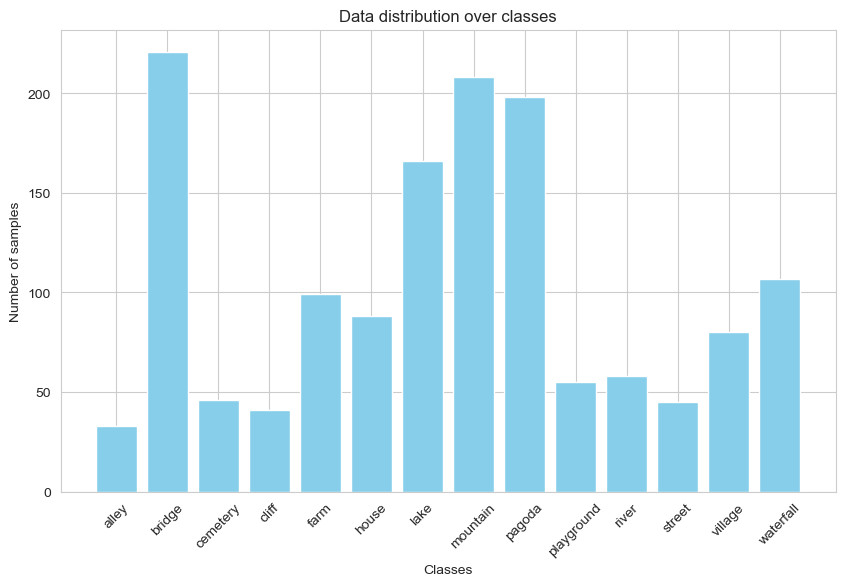

In [30]:
temp_dataset = datasets.ImageFolder(
    root='./train',
    transform=img_transform
)

    


from collections import Counter
class_counts = Counter(temp_dataset.targets)

# Get class names in the same order as labels
class_names = [cls for cls, _ in sorted(new_map.items(), key=lambda x: x[1])]

# Sort counts according to class indices
counts = [class_counts[i] for i in range(len(class_names))]
print(counts)
# Plot
plt.figure(figsize=(10,6))
plt.bar(class_names, counts, color='skyblue')
plt.xlabel("Classes")
plt.ylabel("Number of samples")
plt.title("Data distribution over classes")
plt.xticks(rotation=45)
plt.show()

In [ ]:
model_names = ['resnet18', 'resnet50', 'densenet']

for check_point_path in model_names[1:2]:
    model = loadModel(check_point_path).to(device)
    result_df = evaluate_topk_accuracy(model, custom_loader, 365)
    print(result_df.top_k_accuracy)
    result_df.to_csv(f'{check_point_path}_topk_custom.csv')

In [ ]:

for i, check_point_path in enumerate(check_point_paths):
    model, _ = load_finetuned_model(checkpoint_path=check_point_path, device=device)
    result_df = evaluate_topk_accuracy(model, custom_loader, 365)
    print(result_df.top_k_accuracy)
    result_df.to_csv(f'best_model_{i+1}_topk_custom.csv')

In [ ]:
for i, check_point_path in enumerate(check_point_paths[:3]):
    model, _ = load_finetuned_model(checkpoint_path=check_point_path, device=device)
    result_df = evaluate_topk_accuracy(model, places_loader, 365)
    result_df.to_csv(f'best_model_{i+1}_topk.csv')

In [ ]:
class_counts = Counter(custom_dataset.targets)

# Get class names in the same order as labels
class_names = [cls for cls, _ in sorted(new_map.items(), key=lambda x: x[1])]

# Sort counts according to class indices
counts = [class_counts[i] for i in range(len(class_names))]

# Plot
plt.figure(figsize=(10,6))
plt.bar(class_names, counts, color='skyblue')
plt.xlabel("Classes")
plt.ylabel("Number of samples")
plt.title("Data distribution over classes")
plt.xticks(rotation=45)
plt.show()

In [ ]:
rename_images_in_subfolders('./train', dry_run=False)

In [ ]:
with open('./val_256/places365_val.txt', 'r') as f:
    img_paths = ['./val/' + line.strip().split()[0] for line in f]
    print(img_paths[0])
len(img_paths)

In [ ]:
a = [[1, 2], [2, 3], [4, 5]]
